In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:

df = pd.read_json('/content/TelecomX_Data.json')

df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [102]:
df = pd.json_normalize(df)
df.head()


""
0
1
2
3
4


In [103]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Empty DataFrame


In [104]:
import json

# Re-load the raw JSON data from the file
with open('/content/TelecomX_Data.json') as f:
    data = json.load(f)

# Flatten the JSON data into a DataFrame
# This will automatically expand all nested dictionaries into top-level columns.
df = pd.json_normalize(data)

# Now, df should have columns, and describe() will work correctly.
df.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


In [105]:
df['account.Charges.Total'] = pd.to_numeric(df['account.Charges.Total'], errors='coerce')

In [106]:
df.isnull().sum()


,0
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [107]:
df.dropna(inplace=True)

In [108]:
df['Cuentas_Diarias'] = df['account.Charges.Monthly'] / 30

In [109]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [110]:
df.drop(columns=['customerID'], inplace=True)


In [111]:
df = pd.get_dummies(df, drop_first=True)


In [112]:
df['Churn'].value_counts()


,count
Churn,
0.0,5163
1.0,1869


In [113]:
df['Churn'].value_counts(normalize=True) * 100


,proportion
Churn,
0.0,73.421502
1.0,26.578498


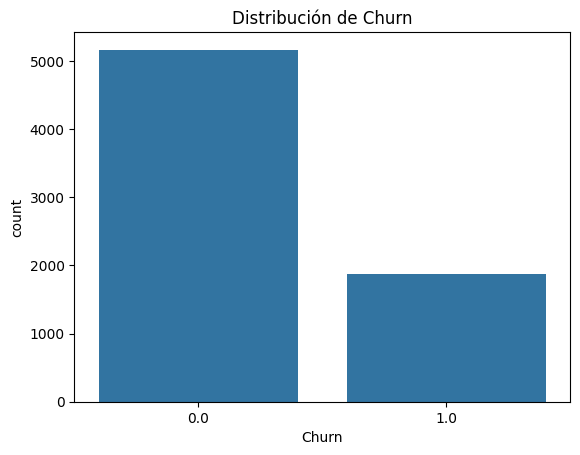

In [114]:
sns.countplot(x='Churn', data=df)
plt.title("Distribución de Churn")
plt.show()

In [115]:
from imblearn.over_sampling import SMOTE

X = df.drop('Churn', axis=1)
y = df['Churn']

# Ensure y (and corresponding X rows) do not contain NaNs
nan_in_y_mask = y.isna()
if nan_in_y_mask.any():
    print(f"Warning: {nan_in_y_mask.sum()} NaNs found in 'Churn' column. Removing corresponding rows.")
    X = X[~nan_in_y_mask]
    y = y[~nan_in_y_mask]

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

y_res.value_counts()

,count
Churn,
0.0,5163
1.0,5163


In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.3,
    random_state=42
)


In [117]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [118]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)


In [119]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)


In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [121]:
def evaluar_modelo(y_test, y_pred, nombre):
    print(f"\nModelo: {nombre}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("\nMatriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nReporte:")
    print(classification_report(y_test, y_pred))


In [122]:
evaluar_modelo(y_test, y_pred_log, "Regresión Logística")
evaluar_modelo(y_test, y_pred_rf, "Random Forest")



Modelo: Regresión Logística
Accuracy: 0.8353776630083926
Precision: 0.8187059577194107
Recall: 0.8491694352159468
F1-score: 0.8336594911937377

Matriz de Confusión:
[[1310  283]
 [ 227 1278]]

Reporte:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1593
         1.0       0.82      0.85      0.83      1505

    accuracy                           0.84      3098
   macro avg       0.84      0.84      0.84      3098
weighted avg       0.84      0.84      0.84      3098


Modelo: Random Forest
Accuracy: 0.8521626856036152
Precision: 0.8379599741768883
Recall: 0.8624584717607974
F1-score: 0.8500327439423707

Matriz de Confusión:
[[1342  251]
 [ 207 1298]]

Reporte:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      1593
         1.0       0.84      0.86      0.85      1505

    accuracy                           0.85      3098
   macro avg       0.85      0.85      0.85      3098
w

In [123]:
print("RF Entrenamiento:", rf_model.score(X_train, y_train))
print("RF Prueba:", rf_model.score(X_test, y_test))


RF Entrenamiento: 0.9987548422800221
RF Prueba: 0.8521626856036152


In [124]:
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': rf_model.feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias.head(10)


,Variable,Importancia
3,account.Charges.Total,0.154363
1,customer.tenure,0.143997
4,Cuentas_Diarias,0.103568
2,account.Charges.Monthly,0.100548
29,account.PaymentMethod_Electronic check,0.089723
11,internet.InternetService_Fiber optic,0.048581
27,account.PaperlessBilling_Yes,0.043369
26,account.Contract_Two year,0.039689
5,customer.gender_Male,0.022624
10,phone.MultipleLines_Yes,0.020389


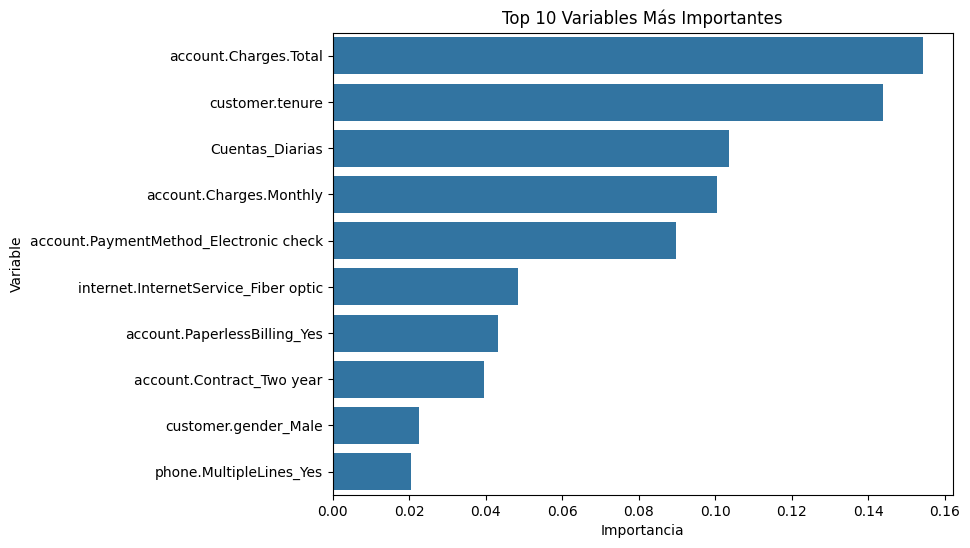

In [125]:
plt.figure(figsize=(8,6))
sns.barplot(x='Importancia', y='Variable', data=importancias.head(10))
plt.title("Top 10 Variables Más Importantes")
plt.show()


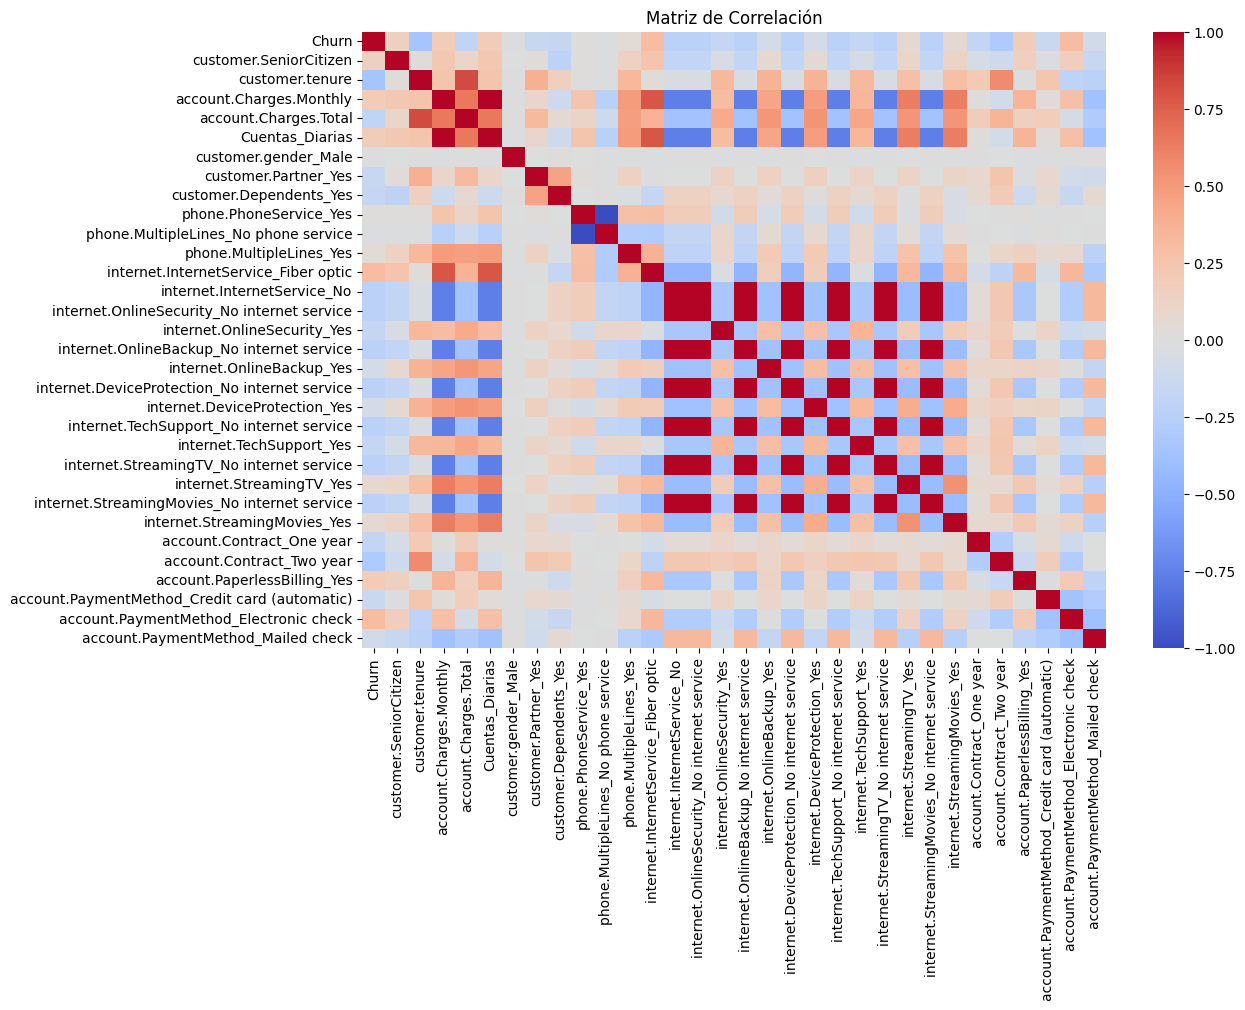

In [126]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()


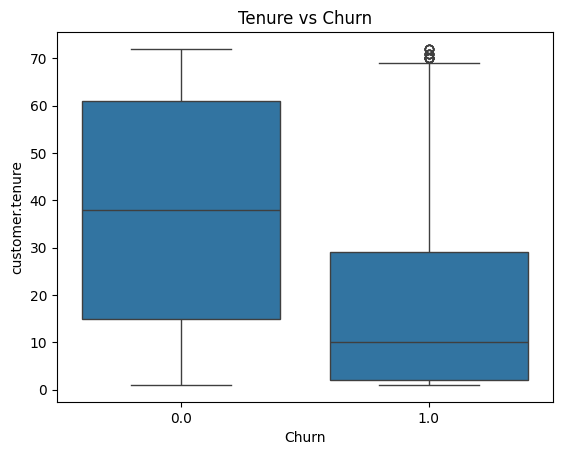

In [127]:
sns.boxplot(x=df['Churn'], y=df['customer.tenure'])
plt.title("Tenure vs Churn")
plt.show()

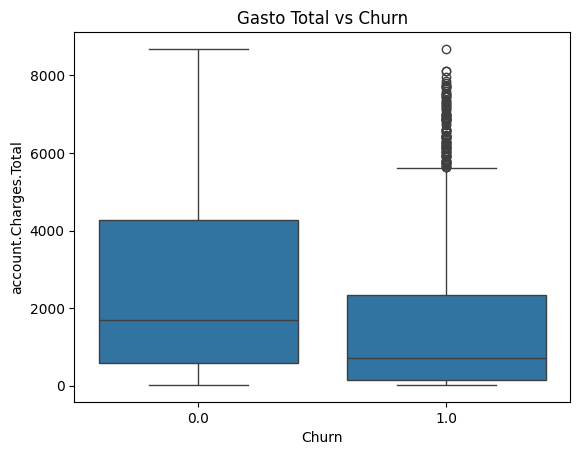

In [128]:
sns.boxplot(x=df['Churn'], y=df['account.Charges.Total'])
plt.title("Gasto Total vs Churn")
plt.show()